In [5]:
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

# Load dataset
df = pd.read_csv('../data/processed/qm9_clean.csv')
smiles_list = df['smiles'].astype('str').tolist()
gap_labels = torch.tensor(df['gap_ev'].values).float()

# Build Vocabulary
chars = sorted(list(set(''.join(smiles_list))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

# Regression dataset builder
max_len = 32 

def build_regression_dataset(smiles, labels):
    X = []
    for s in smiles:
        encoded = [stoi.get(ch, 0) for ch in s[:max_len]]
        padded = encoded + [0] * (max_len - len(encoded))
        X.append(padded)
    return torch.tensor(X), labels

# Shuffle and Split
combined = list(zip(smiles_list, gap_labels))
random.seed(42)
random.shuffle(combined)
smiles_shuffled, gap_shuffled = zip(*combined)
gap_shuffled = torch.stack(gap_shuffled)

n1 = int(0.8*len(smiles_shuffled))
n2 = int(0.9*len(smiles_shuffled))

Xtr, Ytr = build_regression_dataset(smiles_shuffled[:n1], gap_shuffled[:n1])
Xdev, Ydev = build_regression_dataset(smiles_shuffled[n1:n2], gap_shuffled[n1:n2])
Xte, Yte = build_regression_dataset(smiles_shuffled[n2:], gap_shuffled[n2:])

print(f"Train: {Xtr.shape}, Val: {Xdev.shape}")

Train: torch.Size([107108, 32]), Val: torch.Size([13388, 32])


['C',
 'N',
 'O',
 'C#C',
 'C#N',
 'C=O',
 'CC',
 'CO',
 'CC#C',
 'CC#N',
 'CC=O',
 'NC=O',
 'CCC',
 'CCO',
 'COC',
 'C1CC1',
 'C1CO1',
 'CC(C)=O',
 'CC(N)=O',
 'NC(N)=O',
 'CC(C)C',
 'CC(C)O',
 'C#CC#C',
 'C#CC#N',
 'N#CC#N',
 'O=CC#C',
 'O=CC#N',
 'O=CC=O',
 'CC#CC',
 'CCC#C',
 'CCC#N',
 'NCC#N',
 'OCC#C',
 'OCC#N',
 'CCC=O',
 'CNC=O',
 'COC=O',
 'OCC=O',
 'CCCC',
 'CCCO',
 'CCOC',
 'OCCO',
 'CC1CC1',
 'CC1CO1',
 'CN1CC1',
 'OC1CC1',
 'C1CCC1',
 'C1COC1',
 'CC(C)=NO',
 'N1C=CC=C1',
 'N1C=CN=C1',
 'O1C=CC=C1',
 'O1C=CN=C1',
 'CC(C)(C)C',
 'CC(C)(C)O',
 'CC(=O)C#C',
 'CC(=O)C#N',
 'NC(=N)C#N',
 'NC(=O)C#C',
 'CC(=O)C=O',
 'NC(=N)C=O',
 'NC(=O)C=O',
 'CC(C)C#C',
 'CC(C)C#N',
 'CC(N)C#N',
 'CC(O)C#C',
 'CC(O)C#N',
 'CC(C)C=O',
 'CC(O)C=O',
 'CN(C)C=O',
 'CC(=O)CO',
 'CCC(C)=O',
 'CCC(N)=O',
 'CNC(C)=O',
 'CNC(N)=O',
 'COC(C)=N',
 'COC(C)=O',
 'COC(N)=O',
 'NC(=O)CO',
 '[NH3+]CC([O-])=O',
 'CC(C)CO',
 'CC(O)CO',
 'CCC(C)C',
 'CCC(C)O',
 'COC(C)C',
 'CC1(C)CC1',
 'CC1(C)CO1',
 'CC1(O)CC1',

In [7]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps, self.momentum, self.training = eps, momentum, True
        self.gamma, self.beta = torch.ones(dim), torch.zeros(dim)
        self.running_mean, self.running_var = torch.zeros(dim), torch.ones(dim)
    def __call__(self, x):
        if self.training:
            dim = (0, 1) if x.ndim == 3 else 0
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean, xvar = self.running_mean, self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [8]:
n_embd = 24
n_hidden = 512

model = Sequential([
    Embedding(vocab_size, n_embd), # (B, 32, 24)
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # (B, 16, 512)
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # (B, 8, 512)
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # (B, 4, 512)
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # (B, 2, 512)
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # (B, 512)
    Linear(n_hidden, 1), # Output 1 single float for regression
])

parameters = model.parameters()
for p in parameters:
    p.requires_grad = True

max_steps = 50000
batch_size = 64
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward Pass
    logits = model(Xb)
    pred = logits.view(-1)
    loss = F.mse_loss(pred, Yb) # Regression Loss
    
    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.01 if i < 30000 else 0.001
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 5000 == 0:
        print(f'{i:7d}/{max_steps:7d}: MSE Loss = {loss.item():.4f}')
    lossi.append(loss.item())

      0/  50000: MSE Loss = 50.9325
   5000/  50000: MSE Loss = 0.3281
  10000/  50000: MSE Loss = 0.0836
  15000/  50000: MSE Loss = 0.0709
  20000/  50000: MSE Loss = 0.0690
  25000/  50000: MSE Loss = 0.0816
  30000/  50000: MSE Loss = 0.0620
  35000/  50000: MSE Loss = 0.0407
  40000/  50000: MSE Loss = 0.0588
  45000/  50000: MSE Loss = 0.0344


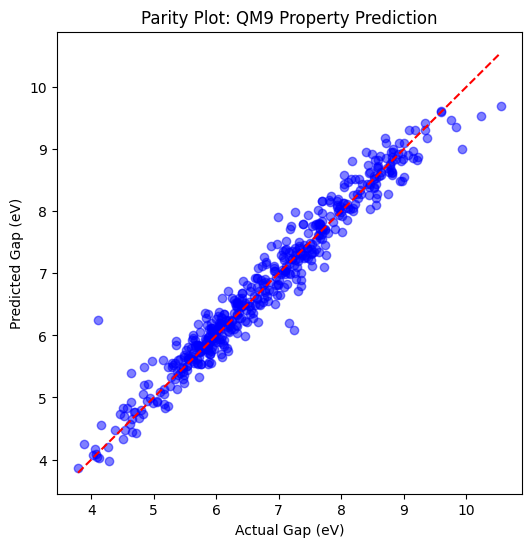

In [11]:
@torch.no_grad()
def plot_parity():
    for layer in model.layers:
        if hasattr(layer, 'training'): layer.training = False
    
    ix = torch.randint(0, Xdev.shape[0], (500,))
    X_sample, Y_sample = Xdev[ix], Ydev[ix]
    
    preds = model(X_sample).view(-1)
    
    plt.figure(figsize=(6,6))
    plt.scatter(Y_sample.numpy(), preds.numpy(), alpha=0.5, color='blue')
    
    plt.plot([Y_sample.min(), Y_sample.max()], [Y_sample.min(), Y_sample.max()], 'r--') 
    
    plt.xlabel('Actual Gap (eV)')
    plt.ylabel('Predicted Gap (eV)')
    plt.title('Parity Plot: QM9 Property Prediction')
    plt.show()

plot_parity()

In [12]:
torch.save(model.parameters(), 'predictor_weights.pt')
print("Weights saved successfully from Task 2.")

Weights saved successfully from Task 2.
